In [7]:
pip install --upgrade protobuf


In [3]:
pip install protobuf==3.20.0

  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.2
    Uninstalling protobuf-4.23.2:
      Successfully uninstalled protobuf-4.23.2
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\KIIT\\anaconda3\\envs\\pytorchenv\\Lib\\site-packages\\google\\~upb\\_message.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [3]:
from pathlib import Path
import torchio as tio
import torch
from model import UNet
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def change_img_to_label_path(path):
    
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [5]:
path = Path("Task03_Liver_rs/imagesTr/")
subjects_paths = list(path.glob("liver_*"))
subjects = []

for subject_path in subjects_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"CT":tio.ScalarImage(subject_path), "Label":tio.LabelMap(label_path)})
    subjects.append(subject)

In [6]:
for subject in subjects:
    assert subject["CT"].orientation==("R","A","S") #RIGHT ANTERIOR SUPERIOR

In [7]:
process=tio.Compose([
    tio.CropOrPad((256,256,200)),
    tio.RescaleIntensity((-1,-1))
])
augmentation=tio.RandomAffine(scales=(0.9,1.1),degrees=(-10,10))
val_transform=process
train_transform=tio.Compose([process,augmentation])

In [8]:
train_dataset=tio.SubjectsDataset(subjects[:105],transform=train_transform)
val_dataset=tio.SubjectsDataset(subjects[:105],transform=val_transform)

sampler=tio.data.LabelSampler(patch_size=96,label_name="Label",label_probabilities={0:0.2,1:0.3,2:0.5})

In [9]:
train_patches_queue=tio.Queue(
train_dataset,
max_length=40,
samples_per_volume=5,
sampler=sampler,
num_workers=4)

val_patches_queue=tio.Queue(
val_dataset,
max_length=40,
samples_per_volume=5,
sampler=sampler,
num_workers=4)

In [10]:
train_loader=torch.utils.data.DataLoader(train_patches_queue,batch_size=2,num_workers=0)
val_loader=torch.utils.data.DataLoader(val_patches_queue,batch_size=2,num_workers=0)

In [11]:
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Val Loss", loss)
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    
    def log_images(self, img, pred, mask, name):
        
        results = []
        pred = torch.argmax(pred, 1) # Take the output with the highest value
        axial_slice = 50  # Always plot slice 50 of the 96 slices
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][:,:,axial_slice]==0, mask[0][:,:,axial_slice])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][:,:,axial_slice]==0, pred[0][:,:,axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)

            
    
    def configure_optimizers(self):

        return [self.optimizer]

In [12]:
model=Segmenter()

In [13]:
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

In [14]:
trainer=pl.Trainer(gpus=0,logger=TensorBoardLogger(save_dir="./logs"),log_every_n_steps=1,
                   callbacks=checkpoint_callback, max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [38]:
trainer.fit(model,train_loader,val_loader)


  | Name    | Type             | Params
---------------------------------------------
0 | model   | UNet             | 5.8 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.344    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\KIIT\anaconda3\envs\pytorchenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

C:\Users\KIIT\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\KIIT\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\KIIT\anaconda3\envs\pytorchenv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [27]:
from IPython.display import HTML
from celluloid import Camera

In [28]:
model = Segmenter.load_from_checkpoint("weights/epoch=97-step=25773.ckpt")
model = model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [29]:
# Select a validation subject and extract the images and segmentation for evaluation
IDX = 4
mask = val_dataset[IDX]["Label"]["data"]
imgs = val_dataset[IDX]["CT"]["data"]

# GridSampler
grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8, 8, 8))
# GridAggregator
aggregator = tio.inference.GridAggregator(grid_sampler)
# DataLoader for speed up
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)


In [30]:
# Prediction
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch['CT']["data"].to(device)  # Get batch of patches
        locations = patches_batch[tio.LOCATION]  # Get locations of patches
        pred = model(input_tensor)  # Compute prediction
        aggregator.add_batch(pred, locations)  # Combine predictions to volume
        
# Extract the volume prediction
output_tensor = aggregator.get_output_tensor()  

C:\Users\KIIT\anaconda3\envs\pytorchenv\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


C:\Users\KIIT\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


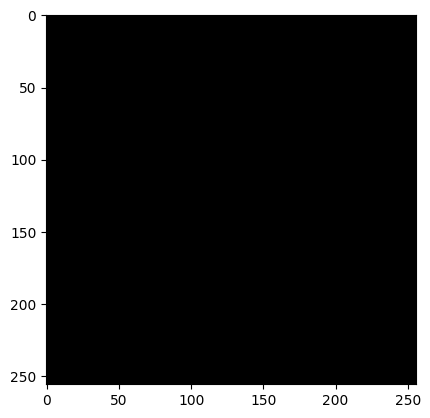

In [31]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[3], 2):  # axial view
    plt.imshow(imgs[0,:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(pred[:,:,i]==0, pred[:,:,i])
    label_mask = np.ma.masked_where(mask[0,:,:,i]==0, mask[0,:,:,i])
    plt.imshow(mask_, alpha=0.1, cmap="autumn")
    #plt.imshow(label_mask, alpha=0.5, cmap="jet")  # Uncomment if you want to see the label

    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation


